# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [1]:
import os
import sys
sys.path.append('/repo/voice-cloning')
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

import sys
sys.path.append('./hifi-gan')
from env import AttrDict
from models import Generator as HiFiGAN

In [2]:
N_SPKS = 247  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [3]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(torch.load('/repo/voice-cloning/voice_cloning/Grad-TTS/logs/text_encoder_2/gradtts_23.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

Number of parameters: 14888680


In [4]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

/repo/voice-cloning/venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Removing weight norm...


In [5]:
text = "My name is Amir"

In [6]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 29]), tensor([29], device='cuda:0'))

In [7]:
spk_embeds_path = params.spk_embeds_path
spks = torch.load(spk_embeds_path)
spks_keys = list(spks.keys())

Grad-TTS RTF: 1.7178591590073529


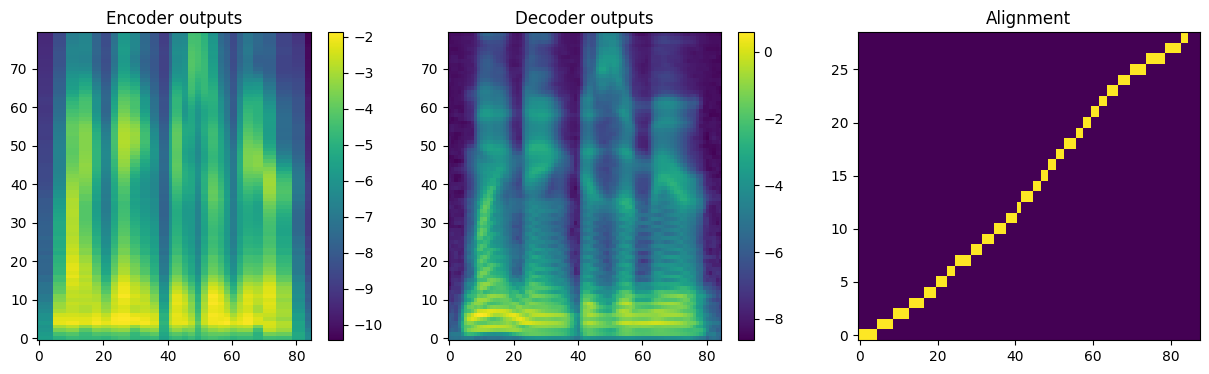

In [ ]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=spks[spks_keys[4]].cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [9]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))